# COM6012 Scalable Machine Learning 2020 - Haiping Lu
# Lab 4: $k$-means clustering

## Objectives

* Task 1: To finish before the next session. **Essential**
* Task 2: To finish before the next session. **Essential**
* Task 3: To explore by yourself. **Optional but recommended**

**Suggested reading**: 
* Chapters 11 and 12 of [PySpark tutorial](https://runawayhorse001.github.io/LearningApacheSpark/pyspark.pdf) 
* [Clustering in Spark](https://spark.apache.org/docs/2.3.2/ml-clustering.html)
* [PySpark API on clustering](https://spark.apache.org/docs/2.3.2/api/python/pyspark.ml.html#pyspark.ml.clustering.KMeans)
* [PySpark code on clustering](https://github.com/apache/spark/blob/master/python/pyspark/ml/clustering.py)
* [$k$-means clustering on Wiki](https://en.wikipedia.org/wiki/K-means_clustering)
* [$k$-means++ on Wiki](https://en.wikipedia.org/wiki/K-means%2B%2B) 
* [$k$-means|| paper](http://theory.stanford.edu/~sergei/papers/vldb12-kmpar.pdf)

<!-- **Tips**
* If you frequently lose HPC connections and are tired of retyping, **save** interactive session in HPC via `screen`. See this tip [here](https://info.hpc.sussex.ac.uk/hpc-guide/how-to/interactive.html) (thanks to George for sharing).-->

https://github.com/haipinglu/ScalableML/

If running this notebook on HPC via [Jupyter Hub](https://jupyter-sharc.shef.ac.uk/), we need to run the following cell. If we are running this notebook on our local machine, skip the following cell.

In [ ]:
import os
import subprocess
def module(*args):        
    if isinstance(args[0], list):        
        args = args[0]        
    else:        
        args = list(args)        
    (output, error) = subprocess.Popen(['/usr/bin/modulecmd', 'python'] + args, stdout=subprocess.PIPE).communicate()
    exec(output)    
module('load', 'apps/java/jdk1.8.0_102/binary')    
os.environ['PYSPARK_PYTHON'] = os.environ['HOME'] + '/.conda/envs/jupyter-spark/bin/python'

## 1. $k$-means clustering

[$k$-means](http://en.wikipedia.org/wiki/K-means_clustering) is one of the most commonly used clustering algorithms that clusters the data points into a predefined number of clusters. The Spark MLlib implementation includes a parallelized variant of the [$k$-means++](https://en.wikipedia.org/wiki/K-means%2B%2B) method called [$k$-means||](http://theory.stanford.edu/~sergei/papers/vldb12-kmpar.pdf).

`KMeans` is implemented as an `Estimator` and generates a `KMeansModel` as the base model.

API: `class pyspark.ml.clustering.KMeans(featuresCol='features', predictionCol='prediction', k=2, initMode='k-means||', initSteps=2, tol=0.0001, maxIter=20, seed=None)`

The following parameters are available:

* *k*: the number of desired clusters. 
* *maxIter*: the maximum number of iterations 
* *initMode*: specifies either random initialization or initialization via k-means|| 
* *initSteps*: determines the number of steps in the k-means|| algorithm (default=2, advanced)
* *tol*: determines the distance threshold within which we consider k-means to have converged.
* *seed*: setting the **random seed** (so that multiple runs have the same results)

#### Start a session

In [1]:
#import findspark
#findspark.init()
import pyspark
from pyspark.ml.clustering import KMeans
from pyspark.ml.clustering import KMeansModel
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
%matplotlib inline


On HPC, you need to install matplotlib via `conda install -c conda-forge matplotlib`
You need to do the same for your own machine if it is not installed.

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local[2]") \
    .appName("COM6012 Kmeans clustering") \
    .getOrCreate()

An example on synthetic data

In [3]:
from pyspark.ml.linalg import Vectors
data = [(Vectors.dense([0.0, 0.0]),), (Vectors.dense([1.0, 1.0]),),  (Vectors.dense([9.0, 8.0]),), (Vectors.dense([8.0, 9.0]),)]
df = spark.createDataFrame(data, ["features"])
kmeans = KMeans(k=2, seed=1)
model = kmeans.fit(df)
centers = model.clusterCenters()
len(centers)

/home/haiping/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


2

Compute the standard $k$-means cost, i.e., the sum of squared distances of points to their nearest center

In [4]:
>>> model.computeCost(df)

2.0000000000000004

Shows the centers (centroids).

In [5]:
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[8.5 8.5]
[0.5 0.5]


In [6]:
transformed = model.transform(df).select("features", "prediction")
rows = transformed.collect()
rows[0].prediction == rows[1].prediction

True

In [7]:
rows

[Row(features=DenseVector([0.0, 0.0]), prediction=1),
 Row(features=DenseVector([1.0, 1.0]), prediction=1),
 Row(features=DenseVector([9.0, 8.0]), prediction=0),
 Row(features=DenseVector([8.0, 9.0]), prediction=0)]

In [8]:
rows[2].prediction == rows[3].prediction

True

In [9]:
 model.hasSummary

True

In [10]:
summary = model.summary
summary.k

2

In [11]:
summary.clusterSizes

[2, 2]

Save the learned model in a tempory location (see [API on save](https://spark.apache.org/docs/2.3.2/api/python/pyspark.ml.html?highlight=save#pyspark.ml.PipelineModel.save))

In [12]:
import tempfile

temp_path = tempfile.mkdtemp()
kmeans_path = temp_path + "/kmeans"
kmeans.save(kmeans_path)
kmeans2 = KMeans.load(kmeans_path)
kmeans2.getK()

2

In [13]:
model_path = temp_path + "/kmeans_model"
model.save(model_path)
model2 = KMeansModel.load(model_path)
model2.hasSummary

False

In [14]:
model.clusterCenters()[0] == model2.clusterCenters()[0]

array([ True,  True])

In [15]:
model.clusterCenters()[1] == model2.clusterCenters()[1]

array([ True,  True])

The example below is based on Chapter 11 of [PySpark tutorial](https://runawayhorse001.github.io/LearningApacheSpark/pyspark.pdf), with some changes made
#### Load and inspect the [iris data](https://archive.ics.uci.edu/ml/datasets/iris)

In [16]:
df = spark.read.load("Data/iris.csv",
                     format="csv", inferSchema="true", header="true")

In [17]:
df.show(5,True)
df.printSchema()

+------------+-----------+------------+-----------+-------+
|sepal_length|sepal_width|petal_length|petal_width|species|
+------------+-----------+------------+-----------+-------+
|         5.1|        3.5|         1.4|        0.2| setosa|
|         4.9|        3.0|         1.4|        0.2| setosa|
|         4.7|        3.2|         1.3|        0.2| setosa|
|         4.6|        3.1|         1.5|        0.2| setosa|
|         5.0|        3.6|         1.4|        0.2| setosa|
+------------+-----------+------------+-----------+-------+
only showing top 5 rows

root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- species: string (nullable = true)



**`.describe().show()` is very handy to inspect your (big) data for understanding/debugging. Try to use it more often to see.**

In [18]:
df.describe().show()

+-------+------------------+-------------------+------------------+------------------+---------+
|summary|      sepal_length|        sepal_width|      petal_length|       petal_width|  species|
+-------+------------------+-------------------+------------------+------------------+---------+
|  count|               150|                150|               150|               150|      150|
|   mean| 5.843333333333335| 3.0540000000000007|3.7586666666666693|1.1986666666666672|     null|
| stddev|0.8280661279778637|0.43359431136217375| 1.764420419952262|0.7631607417008414|     null|
|    min|               4.3|                2.0|               1.0|               0.1|   setosa|
|    max|               7.9|                4.4|               6.9|               2.5|virginica|
+-------+------------------+-------------------+------------------+------------------+---------+



#### Convert the data to dense vector (features)

In [19]:
# convert the data to dense vector
def transData(data):
    return data.rdd.map(lambda r: [Vectors.dense(r[:-1])]).toDF(['features'])

dfFtrvec= transData(df)
dfFtrvec.show(5, False)

+-----------------+
|features         |
+-----------------+
|[5.1,3.5,1.4,0.2]|
|[4.9,3.0,1.4,0.2]|
|[4.7,3.2,1.3,0.2]|
|[4.6,3.1,1.5,0.2]|
|[5.0,3.6,1.4,0.2]|
+-----------------+
only showing top 5 rows



Run multiple $k$-means with different $k$ and evaluate the clustering results. The method is [Silhouette Analysis](https://en.wikipedia.org/wiki/Silhouette_(clustering)). See [the ClusteringEvaluator API](https://spark.apache.org/docs/2.3.2/api/python/pyspark.ml.html#pyspark.ml.evaluation.ClusteringEvaluator). You can also refer to this [scikit-learn notebook on the same topic](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html). 

**Optional** There are other ways of determining the best $k$. You can learn more about [how to determine $k$](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set). 

In [20]:
import numpy as np
numK=10
silhouettes = np.zeros(numK)
costs= np.zeros(numK)
for k in range(2,numK):
    kmeans = KMeans().setK(k).setSeed(11)
    model = kmeans.fit(dfFtrvec)

    # Make predictions, i.e., get cluster index
    predictions = model.transform(dfFtrvec)

    # K-means cost (sum of squared distances of points to their nearest center)
    costs[k]=model.computeCost(dfFtrvec)
    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()

    silhouettes[k] = evaluator.evaluate(predictions)

In [21]:
predictions.show(5)

+-----------------+----------+
|         features|prediction|
+-----------------+----------+
|[5.1,3.5,1.4,0.2]|         0|
|[4.9,3.0,1.4,0.2]|         0|
|[4.7,3.2,1.3,0.2]|         0|
|[4.6,3.1,1.5,0.2]|         0|
|[5.0,3.6,1.4,0.2]|         0|
+-----------------+----------+
only showing top 5 rows



Plot the cost (sum of squared distances of points to their nearest center, the smaller the better) against $k$. You may need to update/install matplotlib via `conda install -c conda-forge matplotlib`

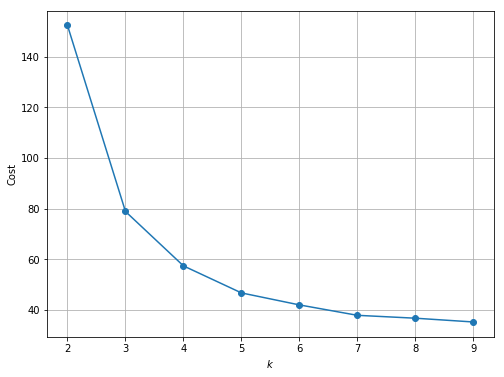

In [22]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,numK),costs[2:numK],marker="o")
ax.set_xlabel('$k$')
ax.set_ylabel('Cost')
plt.grid()
plt.show()

We can see that this cost measure is biased towards a large $k$.

Plot the metric (the larger the better) against $k$. 


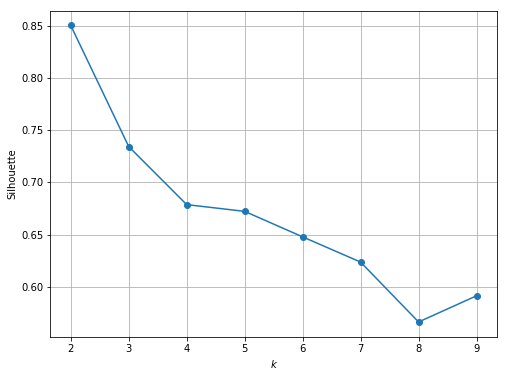

In [23]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,numK),silhouettes[2:numK],marker="o")
ax.set_xlabel('$k$')
ax.set_ylabel('Silhouette')
plt.grid()
plt.show()

We can see that this cost measure is biased towards a small $k$.

By the Silhouette metric, we should choose $k=2$ but we know the ground truth $k$ is 3 (read the data description or count unique species). Therefore, this metric is not giving the ideal results in this case. 

## 2. Exercise - Further analysis of the Iris data (completing two or more questions is considered as completion of this exercise).
* In the iris clustering example, choose $k=3$ and evaluate the clustering results against the ground truth to examine the clustering quality when we know the number of clusters.
* In the iris clustering problem, use (e.g., 10 or 20) random seeds to generate different clustering results and plot the respective errors (with respect to ground truth, with $k=3$) to observe the effect of initialization. 
* Change the initilization method to random and evaluate the results to see whether kmeans || is indeed better.

## 3. Clustering of bigger data (Optional but recommended, completing any of the following is considered as completion of this task.)


### RFM Customer Value Analysis 

* Follow Chapter 12 of [PySpark tutorial](https://runawayhorse001.github.io/LearningApacheSpark/pyspark.pdf) to perform [RFM Customer Value Analysis](https://en.wikipedia.org/wiki/RFM_(customer_value))
* The data can be downloaded from [Online Retail Data Set](https://archive.ics.uci.edu/ml/datasets/online+retail) at UCI. 
* Note the **data cleaning** step that checks and removes rows containing null value via `.dropna()`. You may need to do the same when you are dealing with real data.
* The **data manipulation** steps are also useful to learn.

### Network intrusion detection

* The original task is a classification task. We can ignore the class labels and perform clustering on the data.
* Write a standalone program (and submit as a batch job to HPC) to do $k$-means clustering on the [KDDCUP1999 data](https://archive.ics.uci.edu/ml/datasets/KDD+Cup+1999+Data) with 4M points. You may start with the smaller 10% subset.


### Color Quantization using K-Means
* Follow the scikit-learn example [Color Quantization using K-Means](https://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html#sphx-glr-auto-examples-cluster-plot-color-quantization-py) to perform the same using PySpark on your high-resolution photos.


